# An intro to Bayesian Inference using `pymc3`
Author: Jacob T. Stanley

In [34]:
import numpy as np
import scipy as sp
import pymc3 as pm
import arviz

import matplotlib.pyplot as plt

print(np.__version__, sp.__version__, pm.__version__)

1.18.1 1.6.0 3.8


# References
The following are useful statastical and data handling references for the various tools we are using

## pymc3
* continuous distributions: https://docs.pymc.io/api/distributions/continuous.html
* discrete distributions: https://docs.pymc.io/api/distributions/discrete.html
* Sampling and inference: https://docs.pymc.io/api/inference.html
* Model class: https://docs.pymc.io/api/model.html

## scipy
* statistical functions: https://docs.scipy.org/doc/scipy/reference/stats.html
* special functions package: https://docs.scipy.org/doc/scipy/reference/special.html#module-scipy.special

## numpy
* numpy API: https://numpy.org/doc/stable/reference/index.html

# General Inputs/Outputs

Inputs:
* Data (1D numeric data)
* Rough guess for parameter values (priors)
* The mathematical form of your Model

Run:
* Sampling/Inference
* Convergence check

Output:
* Posterior distributions for each parameter

# Modeling steps
Given some data, the three steps of Bayesian modeling are as follows:
1. Choose priors for your variables
2. Define the model that represents your data
3. MC sample to determine your posterior

# First lets simulate some data
Here we simulate some data that we can use to practice the modeling steps in `pymc3`

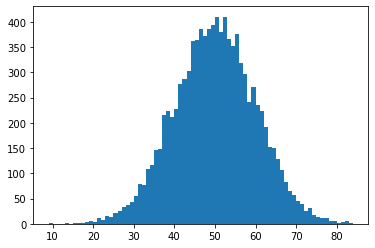

In [10]:
mu = 50
sig = 10

norm_data = sp.stats.norm.rvs(mu, sig, size=10000)

x = np.array(range(int(min(norm_data)), int(max(norm_data))))
plt.hist(norm_data, bins=x);

# Pymc3
Here is the way these steps are performed using `pymc3`


## Instantiate a `Model` context
First you must instantiate a `Model` class in which to build the model

```
with pm.Model() as m:
    ...
    <model code here>
    ...
```

alternatively...

```
m = pm.Model()
```

In [25]:
mod = pm.Model()
print(mod)

## Set your variables equal to their prior distributions
A prior is a distribution and each variable must have one (though it can be a constant). In `pymc3` parlance, the variable is set equal to its prior distribution. There are many distributions to chose from, each with their own parameterization.

```
a = pm.Uniform("var_a", lower=5, upper=30)
b = pm.Exponential("var_b", lam = 0.05)
c = pm.Binomial("var_c", n=4, p=0.5)
```

Variables can be used for the parameters of of other variables. Here the Binomial success probability is modeled by a Beta distribution:

```
prob = pm.Beta('binomial_prob', alpha=5, beta=5)
binom = pm.Binomial('binom_var', n=10, p=prob)
```

In [26]:
with mod:
    norm_mu = pm.Normal('norm_loc', mu=50, sigma=100)
    norm_sig = pm.Exponential('norm_width', lam=1/100)

## Your model for the data is also a variable, but contains the data
The model that describes the data is defined in the same manner as the priors for your variables with the exception that it is also contains the data to which it is compared.

```
norm_mu = pm.Uniform('norm_location', lower=100, upper=500)
norm_sig = pm.Exponential('norm_width', lam=0.001)

observed = pm.Normal('normal_model', mu=norm_mu, sigma=norm_sig, observed=my_data)
```

In [27]:
with mod:
    observed = pm.Normal('normal_model', mu=norm_mu, sigma=norm_sig, observed=norm_data)
mod

## With the model built, we must now sample from it
The model and the corresponding data it is supposed to represent are all contained in our model class object. Sampling can be done in a single line

```
with m:
    trace = pm.sample(10000, cores=1)
```

alternatively...

```
trace = pm.sample(10000, model=m, cores=1)
```

The default sampler is the NUTS sampler, but others are available

```
with m:
    step_method = pm.Metropolis()
    trace = pm.sample(10000, step=step_method, cores=1)
```

In [28]:
with mod:
    trace = pm.sample(1000, cores=1)
    
# cores=1 is not required, but it limits how much of the system resources are used

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [norm_width, norm_loc]
Sampling chain 1, 0 divergences: 100%|████| 1500/1500 [00:03<00:00, 408.74it/s]
The acceptance probability does not match the target. It is 0.8853504444563524, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8975256336260827, but should be close to 0.8. Try to increase the number of tuning steps.


## (Of course all of this can be done in one cell...)

In [29]:
with pm.Model() as mod:
    norm_mu = pm.Normal('norm_loc', mu=50, sigma=100)
    norm_sig = pm.Exponential('norm_width', lam=1/100)
    observed = pm.Normal('normal_model', mu=norm_mu, sigma=norm_sig, observed=norm_data)
    
    # Using the simpler sampler
    step_method = pm.Metropolis()
    trace = pm.sample(10000, step=step_method, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [norm_width]
>Metropolis: [norm_loc]
Sampling chain 1, 0 divergences: 100%|█| 10500/10500 [00:07<00:00, 1325.24it/s]
The number of effective samples is smaller than 10% for some parameters.


## Plot the results of your sampled posteriors
Once you have sampled the posterior distribution of your model, you can plot the results. There are a couple of built in plotting functions to help visualize this.

```
pm.traceplot(trace)
pm.plot_posterior(trace)
```

Or using the `arviz` package which comes with `pymc3` (in newer `pymc3` versions plotting is being assigned solely to `arviz`)

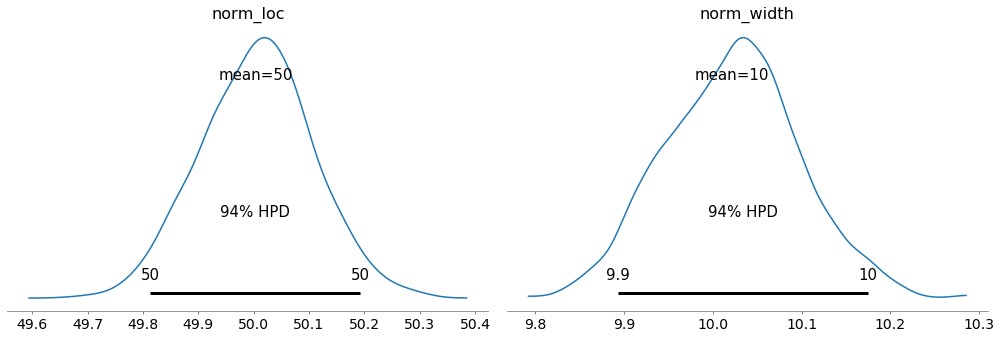

In [33]:
arviz.plot_posterior(trace);

As we can see, the expectation of the posterior distributions reproduce the parameter values used for our simulated data. The HPD (highest-posterior density) gives a "confidence interval" (often called a "credibility interval" in Bayesian parlance) which can be interpreted as the uncertainty on our parameter estimates.

# Let's try with the Gaussian's discrete counterpart
Discrete distributions can also be modeled with `pymc3`, for example the binomial distribution

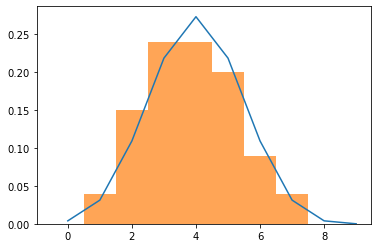

In [60]:
n = 8
p = 0.5
x = np.array(range(0, 10))
binom_pmf = sp.stats.binom.pmf(x, n, p)
binom_data = sp.stats.binom.rvs(n, p, size=100, random_state=42)

plt.plot(x, binom_pmf);
plt.hist(binom_data, bins=x, alpha=0.7, density=True, align='left');

## Let's do a quick aside about the `Beta` distribution
* Continuous distribution over range [0, 1]
* Shape controlled by two parameters `alpha` and `beta`
* Depending on parameter values can be skewed to either side or symmetric about the middle
* Is useful for probability parameters of other distributions

When `alpha` and `beta` are equal to one another and greater than zero the distribution is symmetric about 0.5 with most of the mass at this value instead of in the tails.

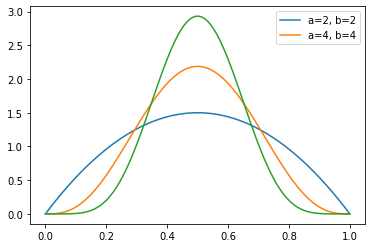

In [62]:
x = np.linspace(0, 1, 100)

a2b2 = sp.stats.beta.pdf(x, 2, 2)
a4b4 = sp.stats.beta.pdf(x, 4, 4)
a7b7 = sp.stats.beta.pdf(x, 7, 7)
plt.plot(x, a2b2)
plt.plot(x, a4b4)
plt.plot(x, a7b7)
plt.legend(['a=2, b=2', 'a=4, b=4']);

When `alpha` and `beta` are less than one (but still equal to one another) the distribution (while still symmetric about 0.5) has most of its mass at the extremes of the range.

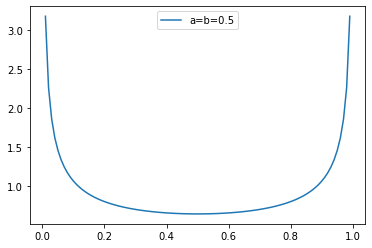

In [63]:
x = np.linspace(0, 1, 100)
ab0p5 = sp.stats.beta.pdf(x, 0.5, 0.5)
#ab0p2 = sp.stats.beta.pdf(x, 0.2, 0.2)
plt.plot(x,ab0p5)
plt.legend(['a=b=0.5']);

When `alpha` and `beta` are NOT equal to one another the distribution is skewed either toward 0 or 1.

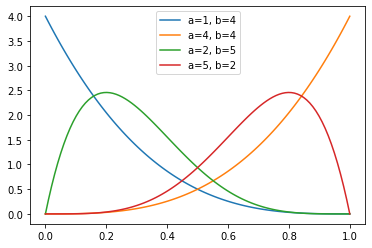

In [65]:
x = np.linspace(0, 1, 100)

a1b4 = sp.stats.beta.pdf(x, 1, 4)
a4b1 = sp.stats.beta.pdf(x, 4, 1)
a2b5 = sp.stats.beta.pdf(x, 2, 5)
a5b2 = sp.stats.beta.pdf(x, 5, 2)
plt.plot(x, a1b4)
plt.plot(x, a4b1)
plt.plot(x, a2b5)
plt.plot(x, a5b2)
plt.legend(['a=1, b=4', 'a=4, b=4', 'a=2, b=5', 'a=5, b=2']);

## So now lets model the binomial data
We do this in the same way as before except that our final model distribution is a discrete one
```
with pm.Model() as m:

    ...parameter stuff first...
    
    binom_obs = pm.Binomial('observed_binomial', n=??, p=??, observed=??)
``` 

In [70]:
n=8
with pm.Model() as model:
    
    prob = pm.Beta('prob_heads', alpha=4, beta=4)
    
    obs = pm.Binomial('obs_binom', n=n, p=prob, observed=binom_data)


In [71]:
with model:
    trace = pm.sample(10000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prob_heads]
Sampling chain 1, 0 divergences: 100%|██| 10500/10500 [00:12<00:00, 829.69it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025356A869C8>],
      dtype=object)

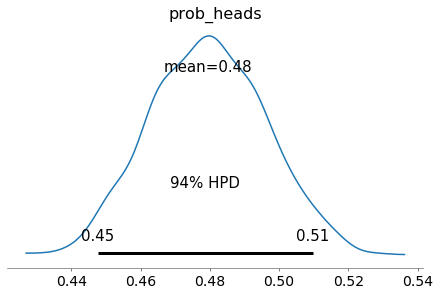

In [67]:
pm.plot_posterior(trace[500:])
# Newer pymc3 versions use a separate package for plotting (arviz):
#arviz.plot_posterior(trace[500:])